In [47]:
# Import some useful libraries
import sys, os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

## Part 2: SCA on ECC implementation
In part 2, we implement a template attack against Elliptic-Curve Cryptography (ECC) implemented on ARM Cortex-M4. The algorithm used is Ed25519 (the EdDSA with the parameters of Curve25519 is referred to as Ed25519).

EdDSA is a variant of the Schnorr digital signature scheme using Twisted Edward Curves, a subgroup of elliptic curves that uses unified formulas, enabling speed-ups for specific curve parameters. This algorithm proposes a deterministic generation of the ephemeral key, different for every message, to prevent flaws from a biased random number generator.
The ephemeral key $r$ is made of the hash value of the message $M$ and the auxiliary key $b$, generating a unique ephemeral public key $R$ for every message.
In this attack, we focus on recovering the ephemeral key by using only one trace of the full scalar multiplication.

The implementation of Ed25519 on Cortex-M4 is a window-based method with radix-16, making use of a precomputed table containing results of the scalar multiplication of $16^i |r_i| \cdot G$, where $r_i\in [-8,7]\cap \mathbb{Z}$ and $G$ is the base point of Curve25519.

To recover the complete key, we will need to operate in the dive-and-conquer approach and recover the 16 parts of the ephemeral key associated with each iteration of the scalar multiplication.

The trace set contains different iterations of the scalar multiplication.
The traceset (78MB) (6\,400 traces, 1k samples each) can be downloaded [here](https://github.com/leoweissbart/MachineLearningBasedSideChannelAttackonEdDSA/raw/master/databaseEdDSA.h5).
The traceset is divided in ['Attack\_traces', 'Profiling\_traces'] and each set contains ['traces', 'label'] containing traces with associated labels. 

### 1) Load dataset

In [67]:
### Load dataset
datasetFileName = os.getcwd() + '/databaseEdDSA.h5'
f = h5py.File(datasetFileName, 'r')
train_data = np.array(f['Profiling_traces/traces'])
train_targets = np.array(f['Profiling_traces/label'])
test_data = np.array(f['Attack_traces/traces'])
test_targets = np.array(f['Attack_traces/label'])

# Print the shape of the loaded data
print("Training data shape: ", train_data.shape)
print("Training labels shape: ", train_targets.shape)
print("Test data shape: ", test_data.shape)
print("Test labels shape: ", test_targets.shape)
print("Total number of traces: ", train_data.shape[0] + test_data.shape[0])
print("Total number of classes: ", len(np.unique(train_targets)))

# Print example of a label in hex
print("Example of a test label in hex: ", hex(test_targets[100]))

Training data shape:  (5120, 1000)
Training labels shape:  (5120,)
Test data shape:  (1280, 1000)
Test labels shape:  (1280,)
Total number of traces:  6400
Total number of classes:  16
Example of a test label in hex:  0xf


### 2) Build the template
Sort the training data by class, according to the training labels (i.e. the different nibble values).
Build multivariate templates for all operations using principal component analysis.
Perform the following procedure (also available [here](https://www.iacr.org/archive/ches2006/01/01.pdf)).
1.  Compute the mean of the all operation $\bar{\mu} = \frac{1}{n\_classes} ∗ \sum_{k=1}^{n\_classes} \mu_k$ , where $\mu_k$ is the mean of operation $k$.
2.  Compute $B = \frac{1}{n\_classes} ∗ \sum_{k=1}^{n\_classes} (\mu_k − \bar{\mu}) ∗ (\mu_k − \bar{\mu})^T$ . The result is a 1000 x 1000 matrix.
3. Perform the singular value decomposition of B, using `U,S,V = np.linalg.svd(B)`.
4. Choose the number of principal components (dimensions), $m$, that you want, i.e. perform `U_reduced = U[:,:m]`. The shape of `U_reduces` is `(1000, m)`.
Choose $m$ by adding your two student numbers mod 5 and looking to the following table.
| (sNum1+SNum2) mod 5 | number of principal components |
| --- | --- |
| 0 | [2,8]   |
| 1 | [3,9]  |
| 2 | [4,10]  |
| 3 | [5,11]  |
<br>
5. Project all datasets (profiling and attack datasets)  using `U_reduced`, i.e. perform matrix multiplication to produce matrices of shape `(n_train_traces, m)` and `(n_test_traces, m)`.
6. Compute the mean vector and the covariance matrix from the projected training dataset, i.e. build the multivariate templates using Numpy functions `np.mean` and `np.cov`.

In [49]:
# Sort the training data by class
num_classes = 16
class_traces = [[] for _ in range(num_classes)]

for i in range(train_data.shape[0]):
    label = train_targets[i]
    class_traces[label].append(train_data[i])

# Convert lists to numpy arrays
class_traces = [np.array(class_traces[i]) for i in range(num_classes)]

# Print the number of traces per class
for i in range(num_classes):
    print("Number of traces for class ", i, " : ", len(class_traces[i]))

Number of traces for class  0  :  317
Number of traces for class  1  :  314
Number of traces for class  2  :  315
Number of traces for class  3  :  321
Number of traces for class  4  :  320
Number of traces for class  5  :  316
Number of traces for class  6  :  313
Number of traces for class  7  :  325
Number of traces for class  8  :  323
Number of traces for class  9  :  330
Number of traces for class  10  :  314
Number of traces for class  11  :  317
Number of traces for class  12  :  306
Number of traces for class  13  :  332
Number of traces for class  14  :  322
Number of traces for class  15  :  335


In [50]:
# Calculate the mean of each class
mean_vectors = np.zeros((num_classes, train_data.shape[1]))
for i in range(num_classes):
    mean_vectors[i] = np.mean(class_traces[i], axis=0)

# Compute the mean of all operations
overall_mean = np.mean(mean_vectors, axis=0)

print("Shape of the mean vectors: ", mean_vectors.shape)
print("Shape of the overall mean vector: ", overall_mean.shape)

Shape of the mean vectors:  (16, 1000)
Shape of the overall mean vector:  (1000,)


In [51]:
# Compute B matrix
B = np.zeros((train_data.shape[1], train_data.shape[1]))
for i in range(num_classes):
    diff = (mean_vectors[i] - overall_mean).reshape(-1, 1)
    B += np.dot(diff, diff.T)
B /= num_classes

# Print the shape of the B matrix
print("Shape of the B matrix: ", B.shape)

Shape of the B matrix:  (1000, 1000)


In [24]:
# Perform singular value decomposition
U, S, V = np.linalg.svd(B)

# Print information about the singular values
print("Shape of U: ", U.shape)
print("Shape of S: ", S.shape)
print("Shape of V: ", V.shape)

Shape of U:  (1000, 1000)
Shape of S:  (1000,)
Shape of V:  (1000, 1000)


In [52]:
# Choose the number of principal components
sNum1 = 1132644  # Student number 1
sNum2 = 1112354  # Student number 2
m_values = [(2, 8), (3, 9), (4, 10), (5, 11)]
m_index = (sNum1 + sNum2) % 5
m1, m2 = m_values[m_index]

# Print the chosen number of principal components
print("Chosen index: ", m_index)
print("Chosen number of principal components: ", m1, m2)

Chosen index:  3
Chosen number of principal components:  5 11


In [68]:
# Function to build templates for given number of principal components
def build_and_project_templates(U_reduced, train_data, train_targets, test_data):
    # Project all datasets using U_reduced
    projected_train_data = np.dot(train_data, U_reduced)
    projected_test_data = np.dot(test_data, U_reduced)

    # Compute the mean vector and the covariance matrix from the projected training dataset
    num_classes = 16
    mean_matrix = np.zeros((num_classes, U_reduced.shape[1]))
    cov_matrix = np.zeros((num_classes, U_reduced.shape[1], U_reduced.shape[1]))

    for i in range(num_classes):
        projected_class_data = projected_train_data[train_targets == i]
        mean_matrix[i] = np.mean(projected_class_data, axis=0)
        cov_matrix[i] = np.cov(projected_class_data, rowvar=False)

    return projected_train_data, projected_test_data, mean_matrix, cov_matrix

In [69]:
# Build templates for m1
U_reduced_m1 = U[:, :m1]
projected_train_data_m1, projected_test_data_m1, mean_matrix_m1, cov_matrix_m1 = build_and_project_templates(
    U_reduced_m1, train_data, train_targets, test_data)

# Build templates for m2
U_reduced_m2 = U[:, :m2]
projected_train_data_m2, projected_test_data_m2, mean_matrix_m2, cov_matrix_m2 = build_and_project_templates(
    U_reduced_m2, train_data, train_targets, test_data)

# Print the shapes of the projected datasets
print("Shape of projected training data (m1): ", projected_train_data_m1.shape)
print("Shape of projected test data (m1): ", projected_test_data_m1.shape)
print("Shape of projected training data (m2): ", projected_train_data_m2.shape)
print("Shape of projected test data (m2): ", projected_test_data_m2.shape)

Shape of projected training data (m1):  (5120, 5)
Shape of projected test data (m1):  (1280, 5)
Shape of projected training data (m2):  (5120, 11)
Shape of projected test data (m2):  (1280, 11)


In [74]:
# Print the mean and covariance matrices for verification
for i in range(num_classes):
    print(f"Class {i} (m1):")
    print(f"Mean: {mean_matrix_m1[i]}")
    print(f"\nClass {i} (m2):")
    print(f"Mean: {mean_matrix_m2[i]}")
    print("-" * 50)

Class 0 (m1):
Mean: [-0.24518965 -0.02901233 -0.13005212  0.06481997  0.05005056]

Class 0 (m2):
Mean: [-0.24518965 -0.02901233 -0.13005212  0.06481997  0.05005056 -0.01852761
 -0.03795385  0.15376222  0.14991048 -0.0388649  -0.17656644]
--------------------------------------------------
Class 1 (m1):
Mean: [ 0.17623734 -0.07458269 -0.05950601 -0.08197804  0.15140318]

Class 1 (m2):
Mean: [ 0.17623734 -0.07458269 -0.05950601 -0.08197804  0.15140318  0.06755882
 -0.00898944 -0.04952956 -0.00492905 -0.03536164 -0.16082991]
--------------------------------------------------
Class 2 (m1):
Mean: [ 0.17904829  0.0211767  -0.11309669  0.02565534 -0.19435407]

Class 2 (m2):
Mean: [ 0.17904829  0.0211767  -0.11309669  0.02565534 -0.19435407 -0.00077194
  0.01016591 -0.02076344  0.00234519 -0.02435406 -0.17734542]
--------------------------------------------------
Class 3 (m1):
Mean: [ 0.05809742  0.15489228 -0.05389839  0.22286442  0.07789463]

Class 3 (m2):
Mean: [ 0.05809742  0.15489228 -0.05

In [83]:
def check_non_negative_variances(cov_matrix, m):
    all_non_negative = True
    for i in range(num_classes):
        diag_elements = np.diag(cov_matrix[i])
        if np.any(diag_elements < 0):
            print(f"Negative variance found in class {i} for m = {m}.")
            all_non_negative = False
    if all_non_negative:
        print(f"All classes have non-negative variances for m = {m}.")


def visualize_covariance_matrices(cov_matrix, m):
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    fig.suptitle(f'Covariance Matrices for All Classes (m = {m})', fontsize=16)

    for i in range(num_classes):
        ax = axs[i // 4, i % 4]
        sns.heatmap(cov_matrix[i], annot=False, fmt='.2g', cmap='viridis', ax=ax)
        ax.set_title(f'Class {i}')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

All classes have non-negative variances for m = 5.


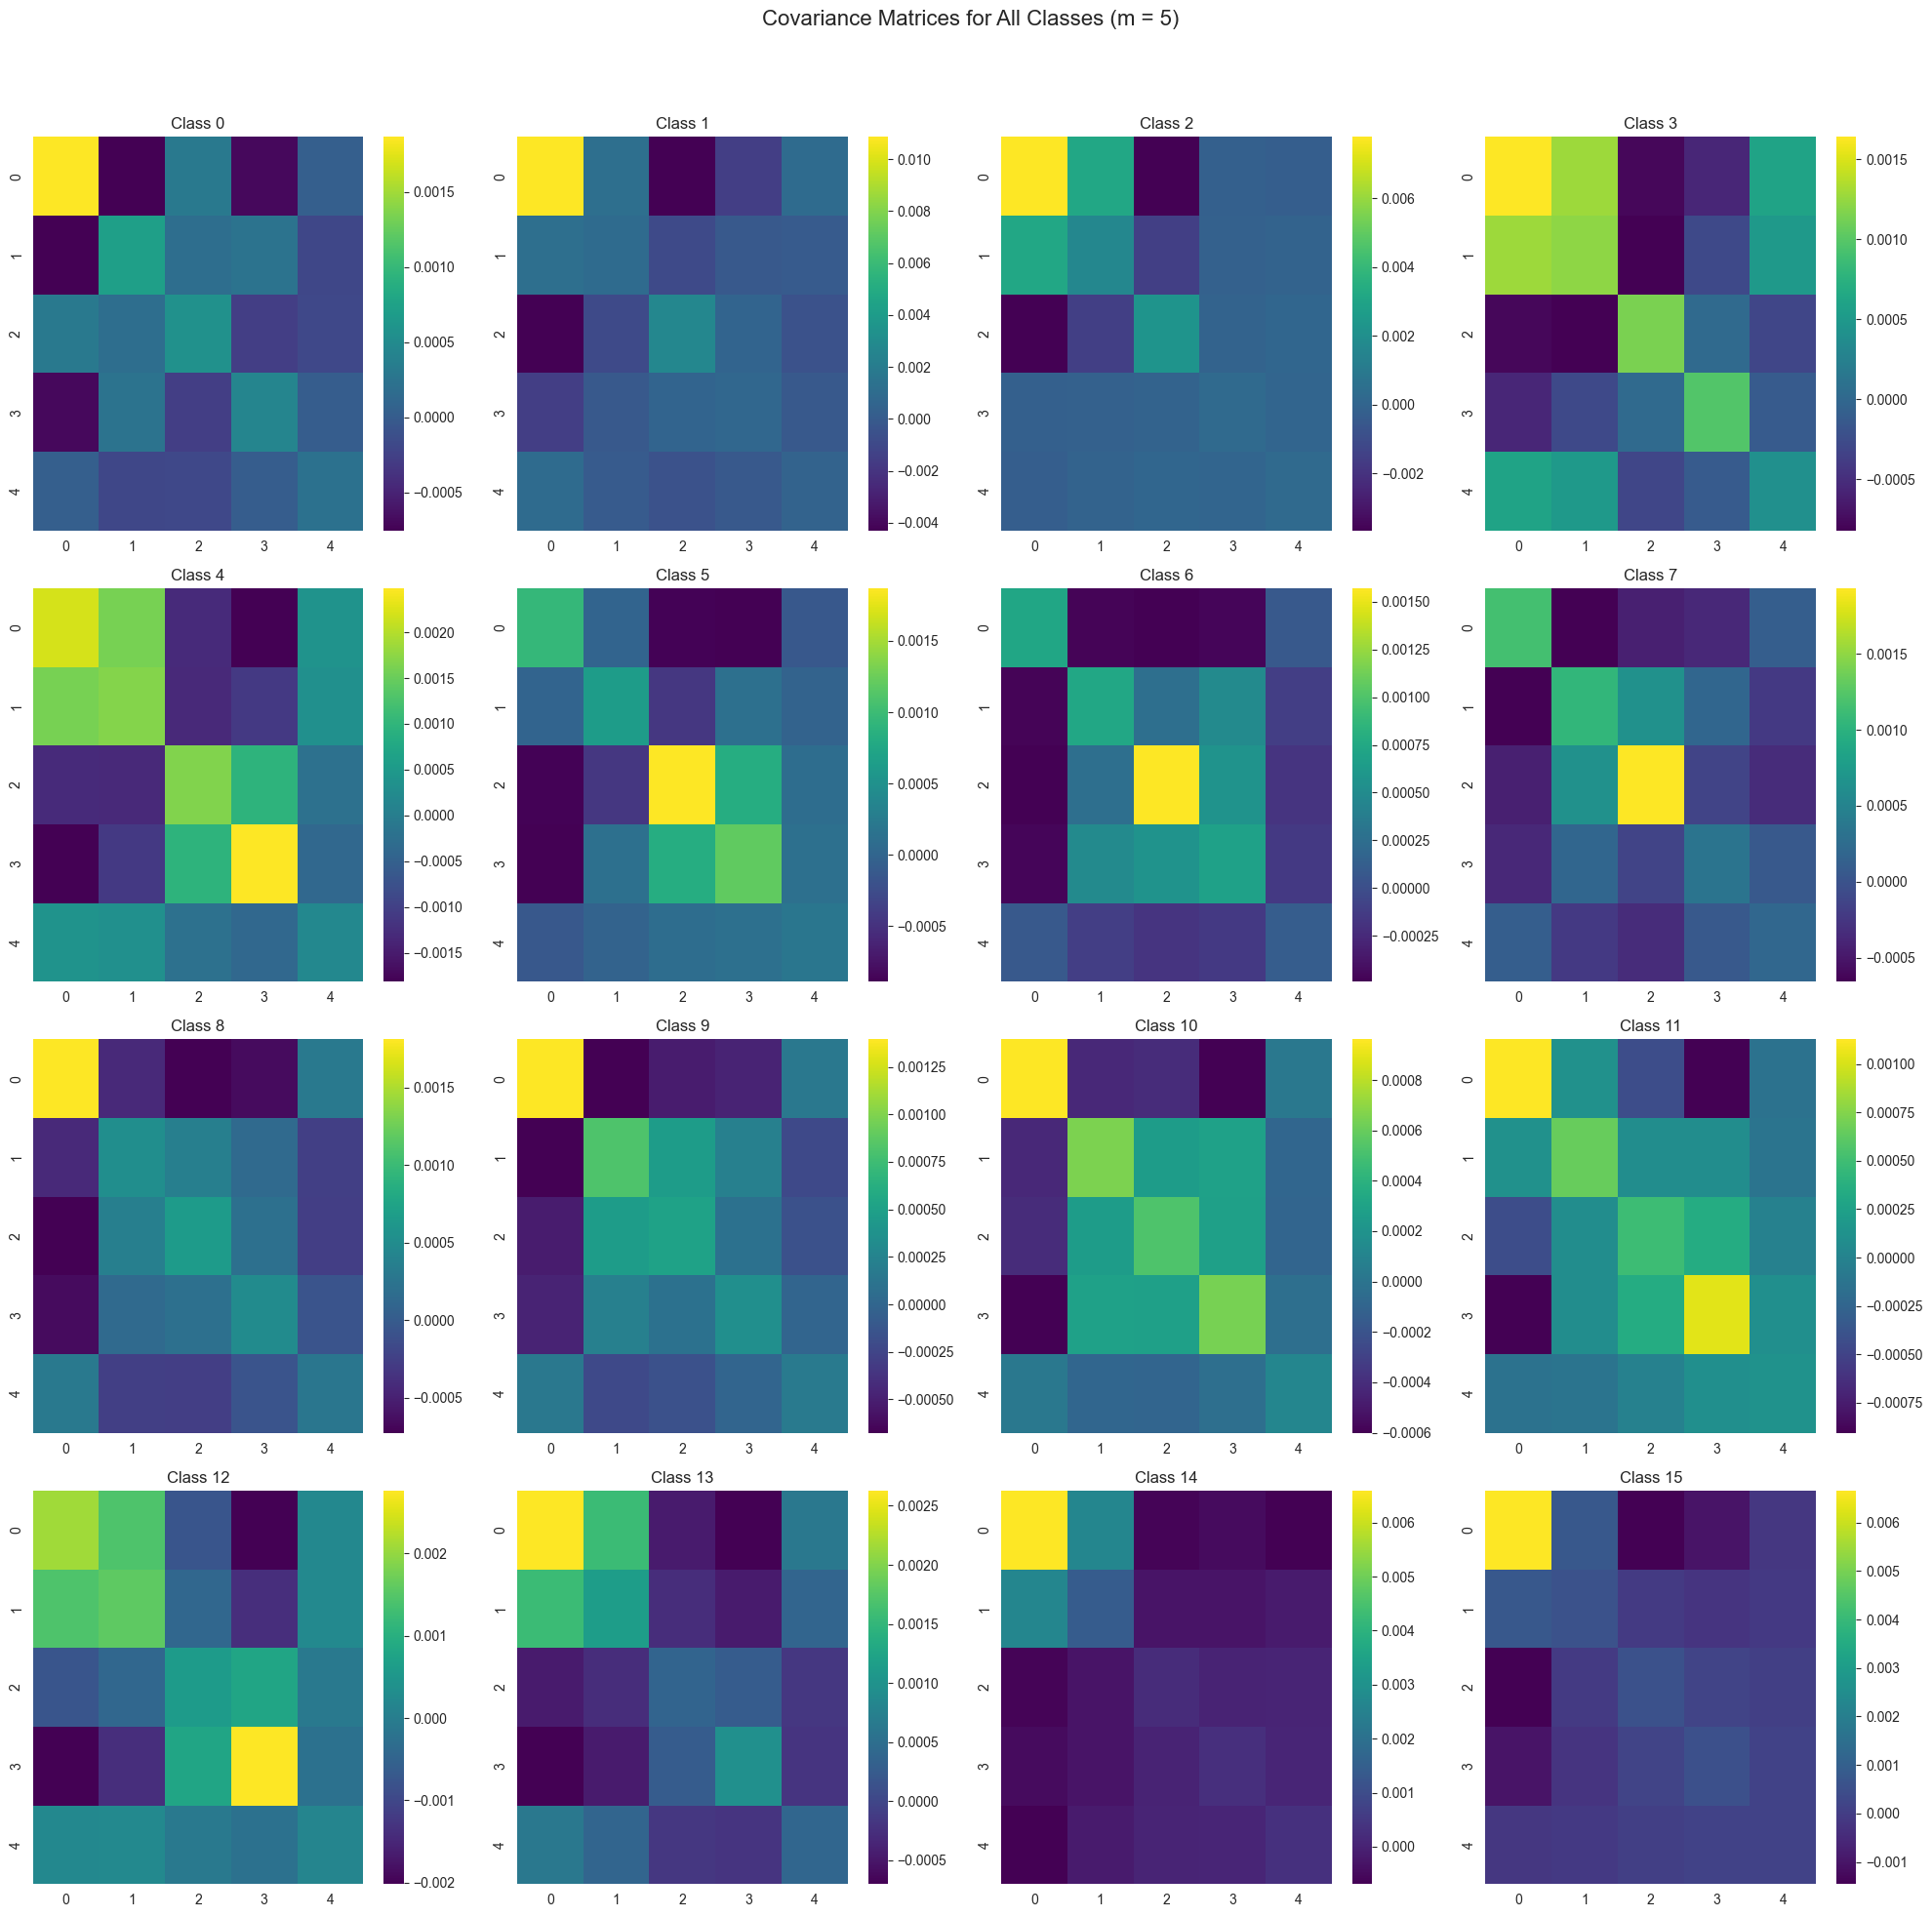

Mean vector (m1) - min: -0.2451896470461925, max: 0.2589566050412964, mean: 0.009572747788171654
Covariance matrix (m1) - min: -0.004300784630285966, max: 0.010854540152151594, mean: 0.000139437889752658


In [84]:
# For m = m1
# Check if all diagonal elements of covariance matrices are non-negative
check_non_negative_variances(cov_matrix_m1, m1)

# Visualize covariance matrices using heatmaps in a 4x4 grid
visualize_covariance_matrices(cov_matrix_m1, m1)

# Summary statistics for mean vectors and covariance matrices
mean_flattened_m1 = mean_matrix_m1.flatten()
cov_flattened_m1 = cov_matrix_m1.flatten()
print(
    f"Mean vector (m1) - min: {mean_flattened_m1.min()}, max: {mean_flattened_m1.max()}, mean: {mean_flattened_m1.mean()}")
print(
    f"Covariance matrix (m1) - min: {cov_flattened_m1.min()}, max: {cov_flattened_m1.max()}, mean: {cov_flattened_m1.mean()}")

All classes have non-negative variances for m = 11.


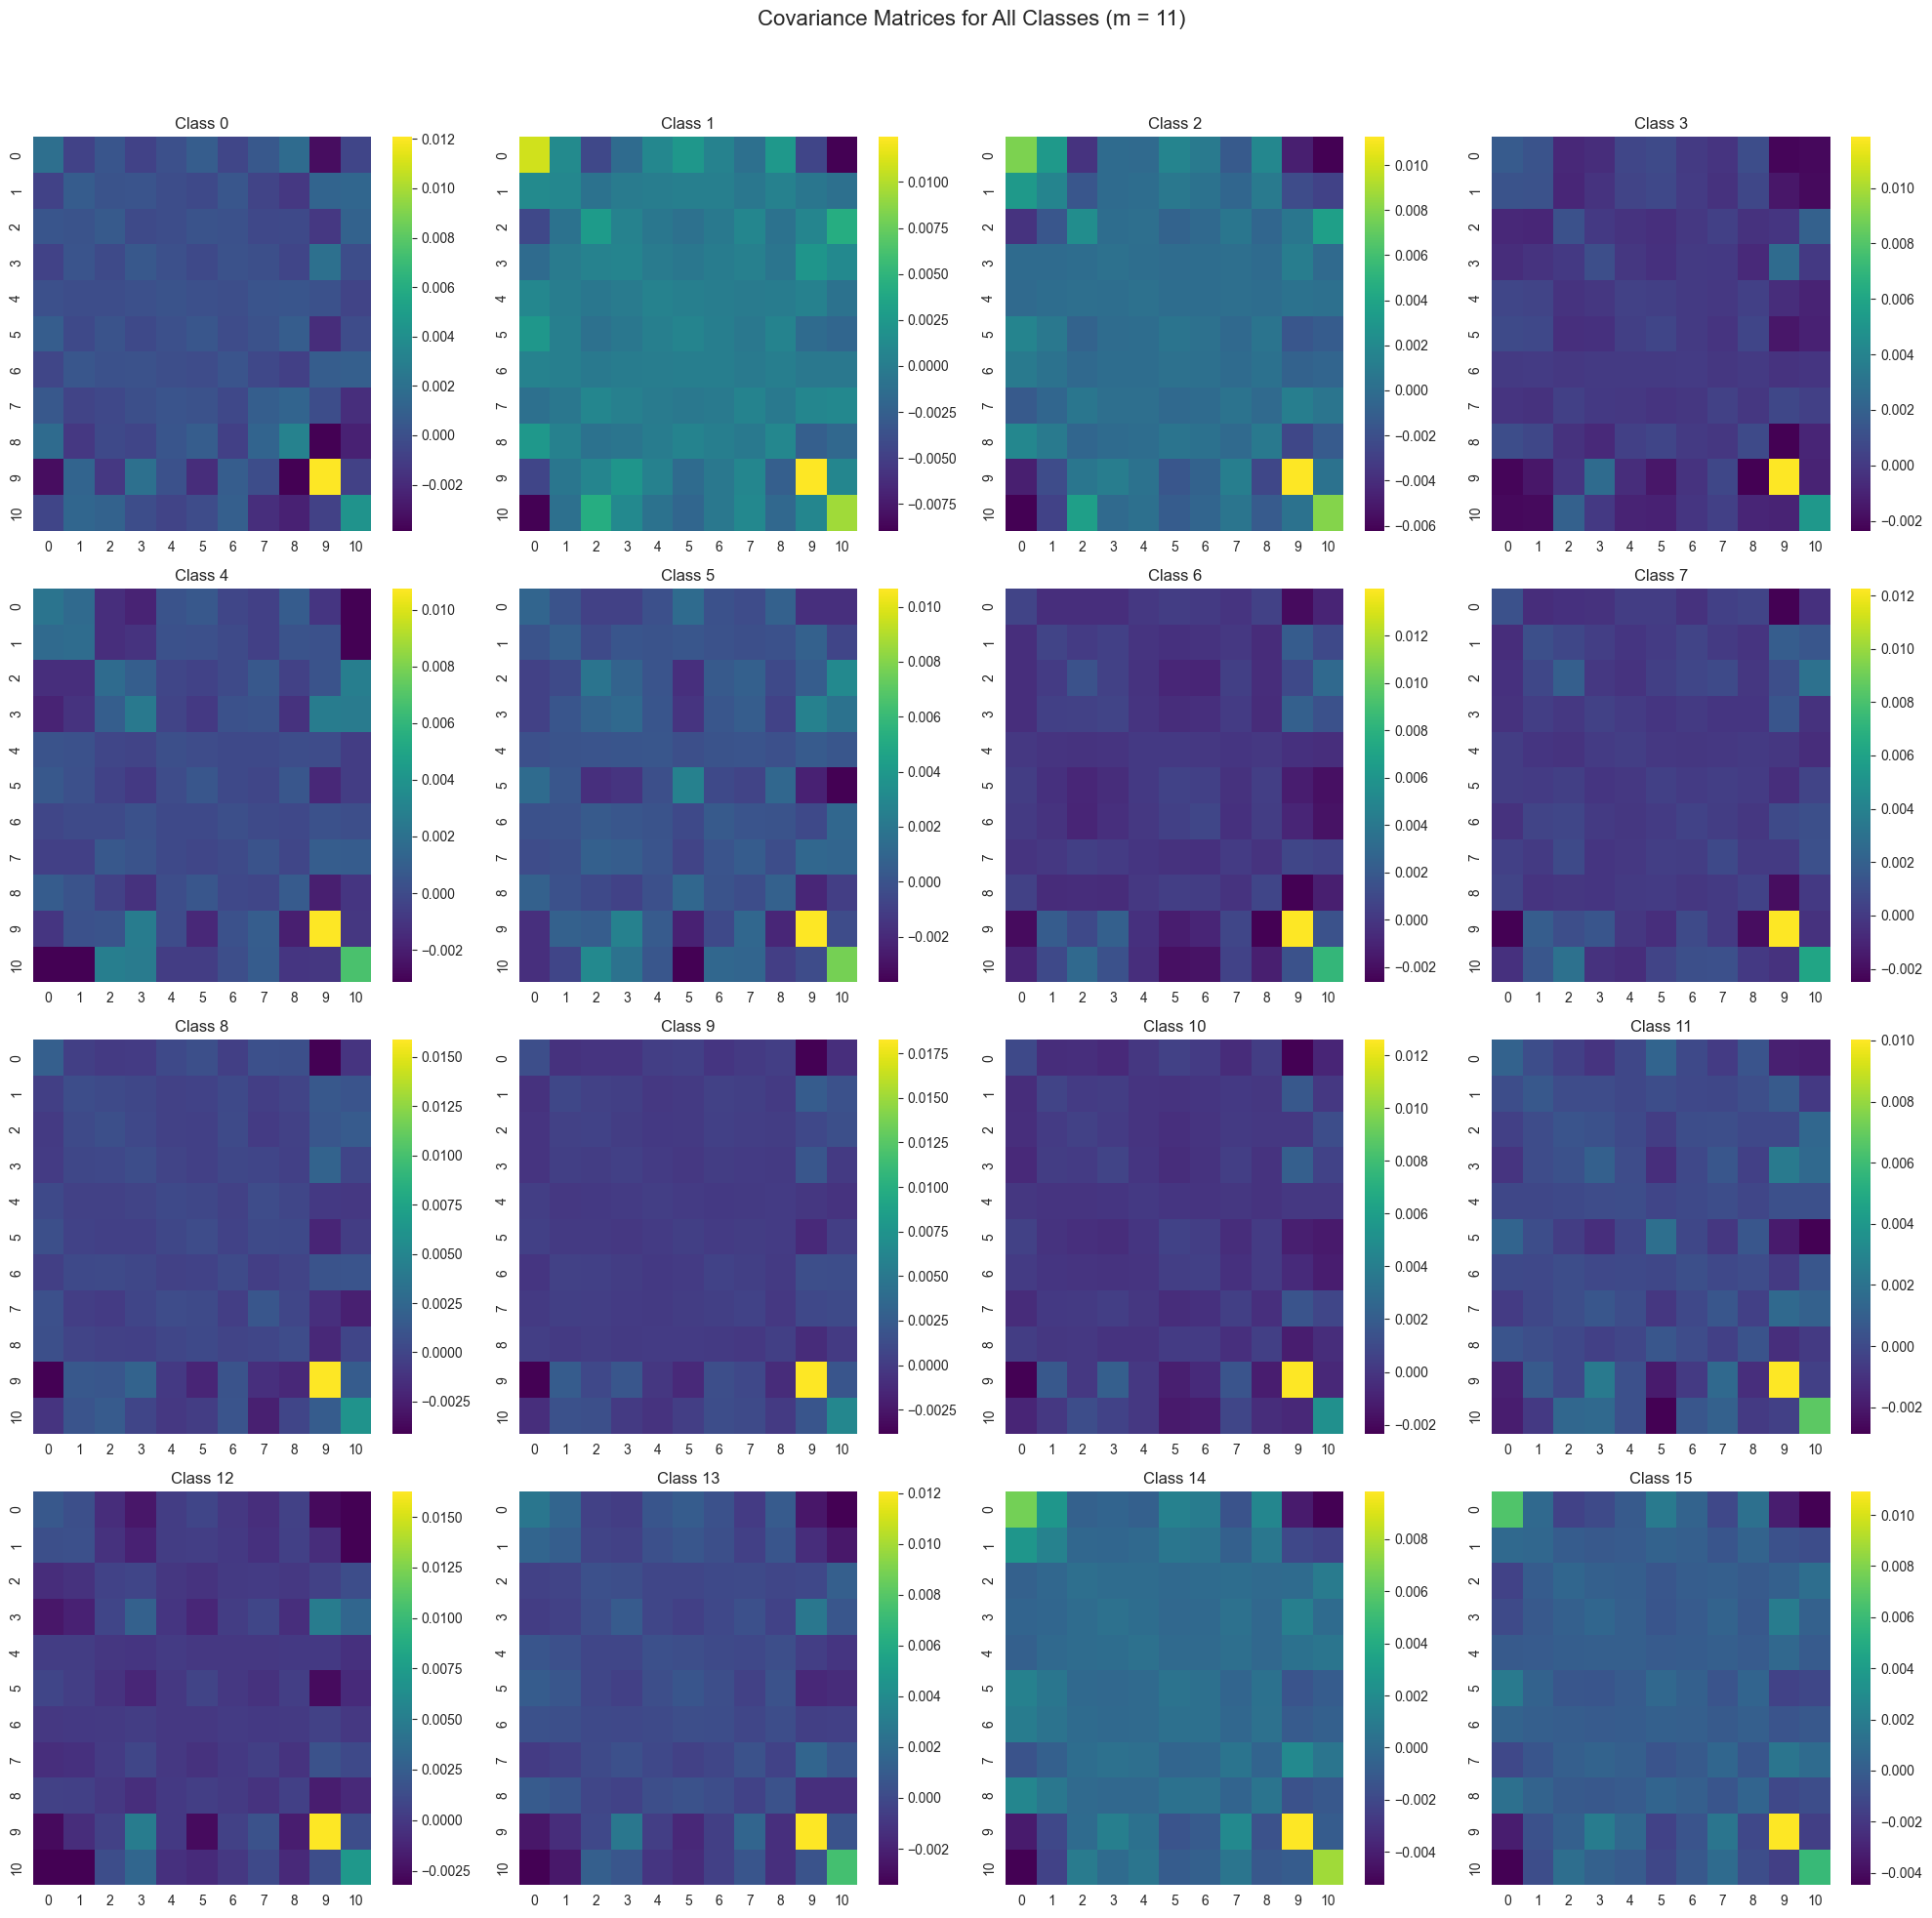

Mean vector (m2) - min: -0.2451896470461925, max: 0.2589566050412964, mean: -0.011158944011874878
Covariance matrix (m2) - min: -0.008957425804106295, max: 0.0182511112777094, mean: 0.00012312622367489578


In [85]:
# For m = m2
# Check if all diagonal elements of covariance matrices are non-negative
check_non_negative_variances(cov_matrix_m2, m2)

# Visualize covariance matrices using heatmaps in a 4x4 grid
visualize_covariance_matrices(cov_matrix_m2, m2)

# Summary statistics for mean vectors and covariance matrices
mean_flattened_m2 = mean_matrix_m2.flatten()
cov_flattened_m2 = cov_matrix_m2.flatten()
print(
    f"Mean vector (m2) - min: {mean_flattened_m2.min()}, max: {mean_flattened_m2.max()}, mean: {mean_flattened_m2.mean()}")
print(
    f"Covariance matrix (m2) - min: {cov_flattened_m2.min()}, max: {cov_flattened_m2.max()}, mean: {cov_flattened_m2.mean()}")

### 3) Apply the template to make predictions
Compute the template prediction for each operation for all traces in the trace set: $p(k)=-\frac{1}{2} * \sum_{i=1}^{n\_traces}(t_i-\mu_k)*C_{inv}*(t_i-\mu_k)^T$, with $C_{inv}$, the inverted pooled covariance matrix, $m_k$, the mean of operation $k$. Once the probabilities for every traces is computed with every key hypothesis, compute the success rate of order from 1 to 16 for the test traceset and plot the result.

In [86]:
# Function to apply templates and build the probability matrix
def apply_templates_and_build_prob_matrix(projected_test_data, mean_matrix, inv_cov_matrix):
    num_traces = projected_test_data.shape[0]
    num_classes = mean_matrix.shape[0]
    prob_matrix = np.zeros((num_traces, num_classes))

    for trace_idx in range(num_traces):
        projected_trace = projected_test_data[trace_idx]
        for key_guess in range(num_classes):
            class_label = key_guess
            p_kj = compute_log_prob(projected_trace, mean_matrix[class_label], inv_cov_matrix)
            prob_matrix[trace_idx, key_guess] = p_kj

    return prob_matrix

In [87]:
# Compute the inverted pooled covariance matrix for m1
pooled_cov_matrix_m1 = np.mean(cov_matrix_m1, axis=0)
inv_pooled_cov_matrix_m1 = np.linalg.inv(pooled_cov_matrix_m1)

# Apply templates for m1
prob_matrix_m1 = apply_templates_and_build_prob_matrix(projected_test_data_m1, mean_matrix_m1, inv_pooled_cov_matrix_m1)

# Print the probability matrix for verification
print("Probability matrix shape (m1): ", prob_matrix_m1.shape)

# Print the best guess for all traces
best_guesses_m1 = np.argmax(prob_matrix_m1, axis=1)
for trace_idx, best_guess in enumerate(best_guesses_m1):
    print(f"Trace {trace_idx + 1:4} -> Best guess: {best_guess:02x}")

Probability matrix shape (m1):  (1280, 16)
Trace    1 -> Best guess: 0f
Trace    2 -> Best guess: 00
Trace    3 -> Best guess: 0c
Trace    4 -> Best guess: 04
Trace    5 -> Best guess: 0a
Trace    6 -> Best guess: 03
Trace    7 -> Best guess: 0c
Trace    8 -> Best guess: 09
Trace    9 -> Best guess: 00
Trace   10 -> Best guess: 0a
Trace   11 -> Best guess: 06
Trace   12 -> Best guess: 07
Trace   13 -> Best guess: 07
Trace   14 -> Best guess: 0d
Trace   15 -> Best guess: 0c
Trace   16 -> Best guess: 0a
Trace   17 -> Best guess: 06
Trace   18 -> Best guess: 06
Trace   19 -> Best guess: 03
Trace   20 -> Best guess: 0b
Trace   21 -> Best guess: 0d
Trace   22 -> Best guess: 03
Trace   23 -> Best guess: 06
Trace   24 -> Best guess: 08
Trace   25 -> Best guess: 02
Trace   26 -> Best guess: 0a
Trace   27 -> Best guess: 0c
Trace   28 -> Best guess: 09
Trace   29 -> Best guess: 01
Trace   30 -> Best guess: 0c
Trace   31 -> Best guess: 01
Trace   32 -> Best guess: 0e
Trace   33 -> Best guess: 03


In [88]:
# Compute the inverted pooled covariance matrix for m2
pooled_cov_matrix_m2 = np.mean(cov_matrix_m2, axis=0)
inv_pooled_cov_matrix_m2 = np.linalg.inv(pooled_cov_matrix_m2)

# Apply templates for m2
prob_matrix_m2 = apply_templates_and_build_prob_matrix(projected_test_data_m2, mean_matrix_m2, inv_pooled_cov_matrix_m2)

# Print the probability matrix for verification
print("Probability matrix shape (m2): ", prob_matrix_m2.shape)

# Print the best guess for all traces
best_guesses_m2 = np.argmax(prob_matrix_m2, axis=1)
for trace_idx, best_guess in enumerate(best_guesses_m2):
    print(f"Trace {trace_idx + 1:4} -> Best guess: {best_guess:02x}")

Probability matrix shape (m2):  (1280, 16)
Trace    1 -> Best guess: 0f
Trace    2 -> Best guess: 00
Trace    3 -> Best guess: 0c
Trace    4 -> Best guess: 04
Trace    5 -> Best guess: 0a
Trace    6 -> Best guess: 03
Trace    7 -> Best guess: 0c
Trace    8 -> Best guess: 09
Trace    9 -> Best guess: 00
Trace   10 -> Best guess: 0a
Trace   11 -> Best guess: 06
Trace   12 -> Best guess: 07
Trace   13 -> Best guess: 07
Trace   14 -> Best guess: 0d
Trace   15 -> Best guess: 0c
Trace   16 -> Best guess: 0a
Trace   17 -> Best guess: 06
Trace   18 -> Best guess: 06
Trace   19 -> Best guess: 03
Trace   20 -> Best guess: 0b
Trace   21 -> Best guess: 0d
Trace   22 -> Best guess: 03
Trace   23 -> Best guess: 06
Trace   24 -> Best guess: 08
Trace   25 -> Best guess: 02
Trace   26 -> Best guess: 0a
Trace   27 -> Best guess: 0c
Trace   28 -> Best guess: 09
Trace   29 -> Best guess: 01
Trace   30 -> Best guess: 0c
Trace   31 -> Best guess: 01
Trace   32 -> Best guess: 0e
Trace   33 -> Best guess: 03


In [89]:
### Compute the success rate of order from 1 to 16 for the test trace set and plot the result
# Function to compute the success rate
def compute_success_rate(prob_matrix, true_keys, order):
    success_count = 0
    for trace_idx in range(prob_matrix.shape[0]):
        sorted_indices = np.argsort(prob_matrix[trace_idx])
        best_guesses = sorted_indices[-order:]
        if true_keys[trace_idx] in best_guesses:
            success_count += 1
    return success_count / prob_matrix.shape[0]

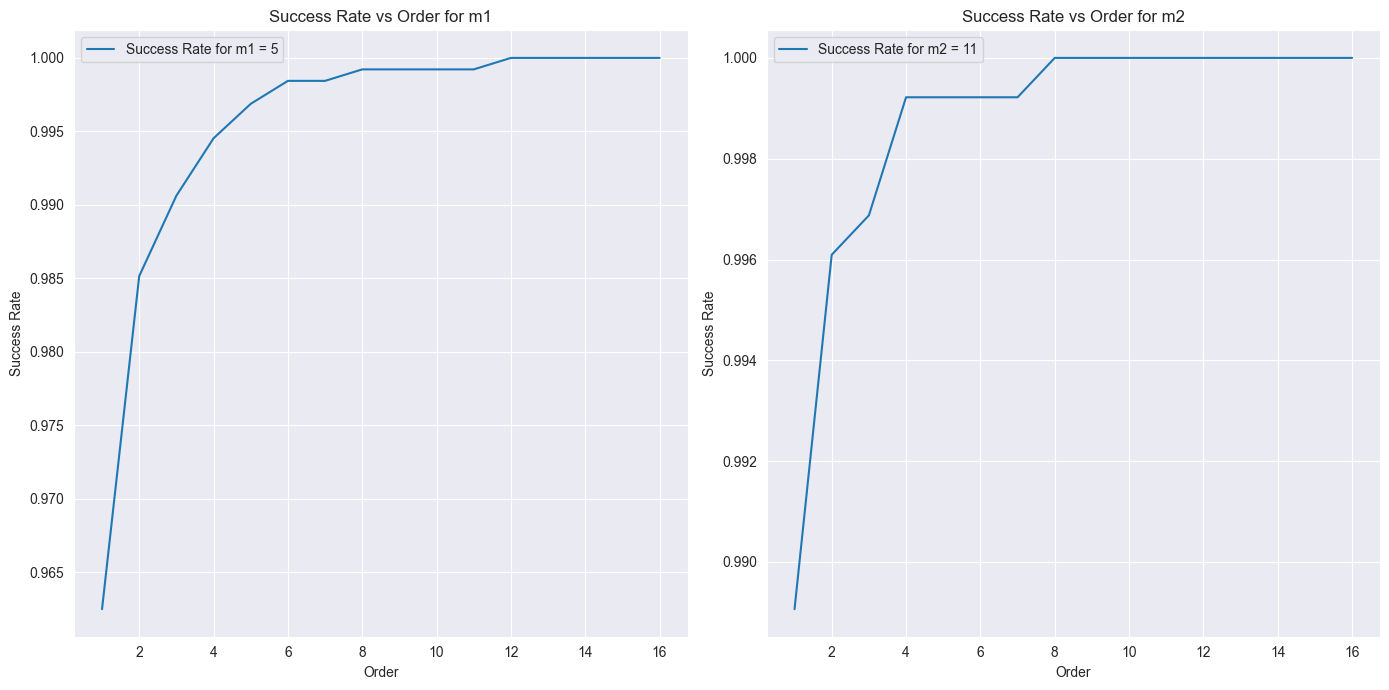

In [100]:
# Initialize a list to store the success rates
success_rates_m1 = []
success_rates_m2 = []

# Calculate success rates for orders from 1 to 16 for m1
true_keys = test_targets  # test_targets contain the true ephemeral key parts
for order in range(1, 17):
    success_rate = compute_success_rate(prob_matrix_m1, true_keys, order)
    success_rates_m1.append(success_rate)

# Calculate success rates for orders from 1 to 16 for m2
for order in range(1, 17):
    success_rate = compute_success_rate(prob_matrix_m2, true_keys, order)
    success_rates_m2.append(success_rate)

# Plot the success rates side by side in subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot for m1
axes[0].plot(range(1, 17), success_rates_m1, label=f'Success Rate for m1 = {m1}')
axes[0].set_xlabel('Order')
axes[0].set_ylabel('Success Rate')
axes[0].set_title('Success Rate vs Order for m1')
axes[0].legend()
axes[0].grid(True)

# Plot for m2
axes[1].plot(range(1, 17), success_rates_m2, label=f'Success Rate for m2 = {m2}')
axes[1].set_xlabel('Order')
axes[1].set_ylabel('Success Rate')
axes[1].set_title('Success Rate vs Order for m2')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [101]:
# Print the success rates for each order for m1 and m2 structured in a table
print("Success rates for m1:")
print("Order | Success Rate")
print("-" * 20)
for order, success_rate in enumerate(success_rates_m1, 1):
    print(f"{order:5} | {success_rate:.4f}")
    
print("\nSuccess rates for m2:")
print("Order | Success Rate")
print("-" * 20)
for order, success_rate in enumerate(success_rates_m2, 1):
    print(f"{order:5} | {success_rate:.4f}")


Success rates for m1:
Order | Success Rate
--------------------
    1 | 0.9625
    2 | 0.9852
    3 | 0.9906
    4 | 0.9945
    5 | 0.9969
    6 | 0.9984
    7 | 0.9984
    8 | 0.9992
    9 | 0.9992
   10 | 0.9992
   11 | 0.9992
   12 | 1.0000
   13 | 1.0000
   14 | 1.0000
   15 | 1.0000
   16 | 1.0000

Success rates for m2:
Order | Success Rate
--------------------
    1 | 0.9891
    2 | 0.9961
    3 | 0.9969
    4 | 0.9992
    5 | 0.9992
    6 | 0.9992
    7 | 0.9992
    8 | 1.0000
    9 | 1.0000
   10 | 1.0000
   11 | 1.0000
   12 | 1.0000
   13 | 1.0000
   14 | 1.0000
   15 | 1.0000
   16 | 1.0000
